Set up environment

In [1]:
from collections import OrderedDict
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

Import custom modules

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../utils/')

# Helper functions for eGLM 
from eGLM_helpers import phi, run_ucr_glm, run_ext_glm, make_stimtimes, sim_network_task_glm, get_res_ts, get_res_taskreg, get_true_baseline, plot_sim_network_glm
import model

Importing eGLM helpers...
All eGLM helpers imported!


Goal of this notebook: Create the most minimal RNN that will be used in the more extended simulations to understand how activity propogates depending on the various parameters.

The network model describes change in activity as follows:

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

In [3]:
ncommunities = 3
innetwork_dsity = .6
outnetwork_dsity = .08
hubnetwork_dsity = .5
nodespercommunity = 3
plot_network = False

totalnodes = nodespercommunity*ncommunities

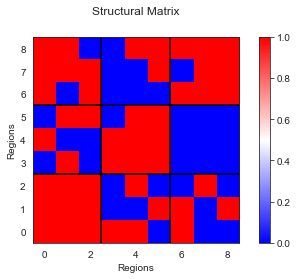

In [4]:
# Construct structural matrix
S = model.generateStructuralNetwork(ncommunities=ncommunities,
                                    innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity,
                                    hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity,
                                    showplot=True)

plt.hlines(y=2.5, xmin = -0.5, xmax = 8.5)
plt.hlines(y=5.5, xmin = -0.5, xmax = 8.5)
plt.vlines(x=2.5, ymin = -0.5, ymax = 8.5)
plt.vlines(x=5.5, ymin = -0.5, ymax = 8.5)

Note in this matrix:

`W[..., x]` : column x of matrix denotes all outgoing connection weights from node x  
`W[x, ...]` : row x of matrix denotes all incoming connection weights to node x

In [5]:
# Construct synaptic matrix
W = model.generateSynapticNetwork(S, showplot=False)

In [6]:
Tmax = 1000
dt = 1
T = np.arange(0,Tmax,dt)

# Construct a community affiliation vector
Ci = np.repeat(np.arange(ncommunities),nodespercommunity) 
# Identify the regions associated with the hub network (hub network is by default the 0th network)
hub_ind = np.where(Ci==0)[0] 

stimsize = nodespercommunity

# This works because if there is a hub network the first nodes are the hub nodes
stim_nodes_td = np.arange(0, stimsize, dtype=int)
#stim_nodes_td

Stimulate network topdown (only the hub nodes) with the following task

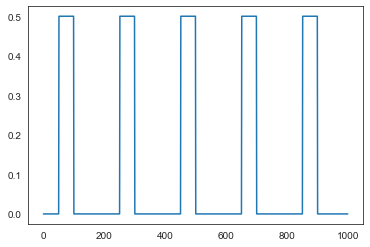

In [7]:
sa = 50
ea = 100
iv = 200
tasktiming, stimtimes = make_stimtimes(Tmax=1000, dt=1, stim_nodes= stim_nodes_td, stim_mag=0.5, sa = sa, ea = ea, iv = iv,
                          ncommunities = ncommunities, nodespercommunity = nodespercommunity)
plt.plot(stimtimes[0])

In [8]:
taskdata, noise = model.networkModel(W, Tmax=Tmax,dt=dt,
                                     g=1, s=1, tau=1, I=stimtimes, 
                                     noise=None)

In [9]:
#Visualize what is going on on the network
#Three scatter plots with three curves for the timeseries/activity of each node in that community
taskdata_df = pd.DataFrame(taskdata)
taskdata_df['node_num'] = taskdata_df.index
taskdata_df['com_num'] = [0,0,0,1,1,1,2,2,2]
taskdata_df = taskdata_df.melt(id_vars = ['node_num', 'com_num'])
taskdata_df = taskdata_df.rename(columns={"variable": "time", "value": "activity"})
#askdata_df

Timeseries/activity for each node in each community.  

Since only the hub network is stimulated by the task the amount of activity will depend on number (/strength) of incoming connections from hub network nodes. If a node does not have any incoming connections from the hub network its activity will not change from 0.

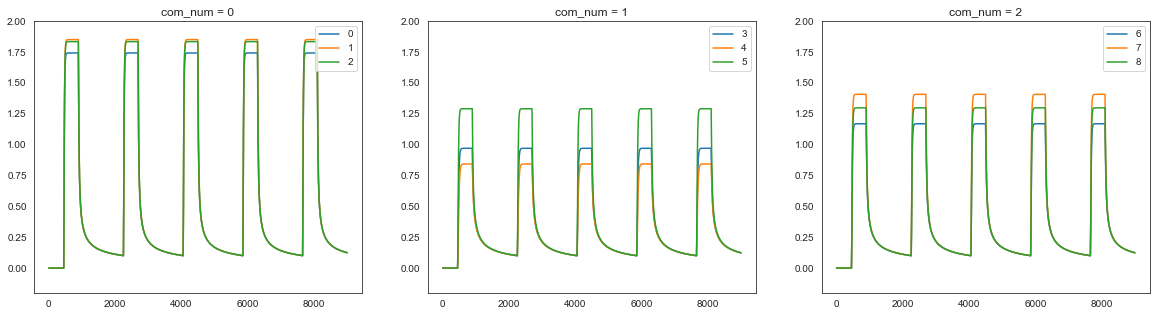

In [10]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 3)

for cur_com in taskdata_df.com_num.unique():
    
    cur_vals = ["C"+str(x) for x in range(len(taskdata_df.query("com_num==@cur_com").node_num.unique()))]
    cur_col_lookup = dict(zip(taskdata_df.query("com_num==@cur_com").node_num.unique(), cur_vals))
    
    for cur_node in taskdata_df.query("com_num==@cur_com").node_num.unique():
        a[cur_com].plot(taskdata_df.query("com_num==@cur_com & node_num==@cur_node")['activity'], color = cur_col_lookup[cur_node], label = cur_node)
        a[cur_com].set_ylim([-0.2,2])
        a[cur_com].set_title("com_num = %s"%(str(cur_com)))
        a[cur_com].legend(loc="upper right")

In [11]:
#Run cGLM and eGLM
base_sim= sim_network_task_glm(ncommunities = ncommunities, 
                         nodespercommunity = nodespercommunity, 
                         dt = 1, tau = 1, g = 1, s = 1, 
                         Tmax = Tmax, 
                         stimsize = nodespercommunity, 
                         stim_mag = .5,
                         W = W,
                         taskdata = taskdata,
                         tasktiming = tasktiming,
                         sa = 50,
                         ea = 100,
                         iv = 200,
                         standardize=True)

base_sim_ns= sim_network_task_glm(ncommunities = ncommunities, 
                         nodespercommunity = nodespercommunity, 
                         dt = 1, tau = 1, g = 1, s = 1, 
                         Tmax = Tmax, 
                         stimsize = nodespercommunity, 
                         stim_mag = .5,
                         W = W,
                         taskdata = taskdata,
                         tasktiming = tasktiming,
                         sa = 50,
                         ea = 100,
                         iv = 200,
                         standardize=False)

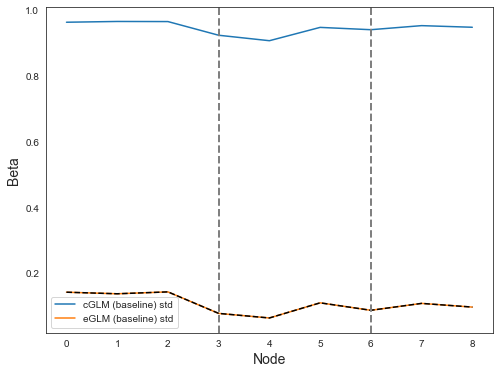

In [12]:
plot_sim_network_glm(base_sim,
                         ncoms = ncommunities,
                         nnods = nodespercommunity,
                         task_type = "td",
                         ucr_label = "cGLM (baseline) std",
                         ext_label = "eGLM (baseline) std",
                         base_label = None,
                         alp = 1,
                         stim_nodes = range(3),
                         tasktiming = None, sa = 50, ea = 100, iv = 20)

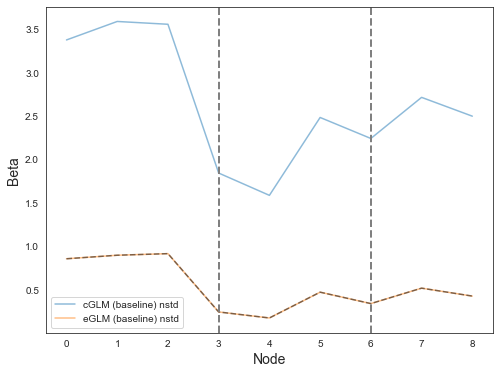

In [13]:
plot_sim_network_glm(base_sim_ns,
                         ncoms = ncommunities,
                         nnods = nodespercommunity,
                         task_type = "td",
                         ucr_label = "cGLM (baseline) nstd",
                         ext_label = "eGLM (baseline) nstd",
                         base_label = None,
                         alp = .5,
                         stim_nodes = range(3),
                         tasktiming = None, sa = 50, ea = 100, iv = 20)